Fitting 5 folds for each of 200 candidates, totalling 1000 fits


<ipython-input-17-67f9d91e28cb>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Mean Absolute Error (MAE): 30.412504498499807
Mean Squared Error (MSE): 17203.47863223319
Root Mean Squared Error (RMSE): 131.1620319766097
Modified Mean Absolute Percentage Error (MMAPE): 0.12751927231001722


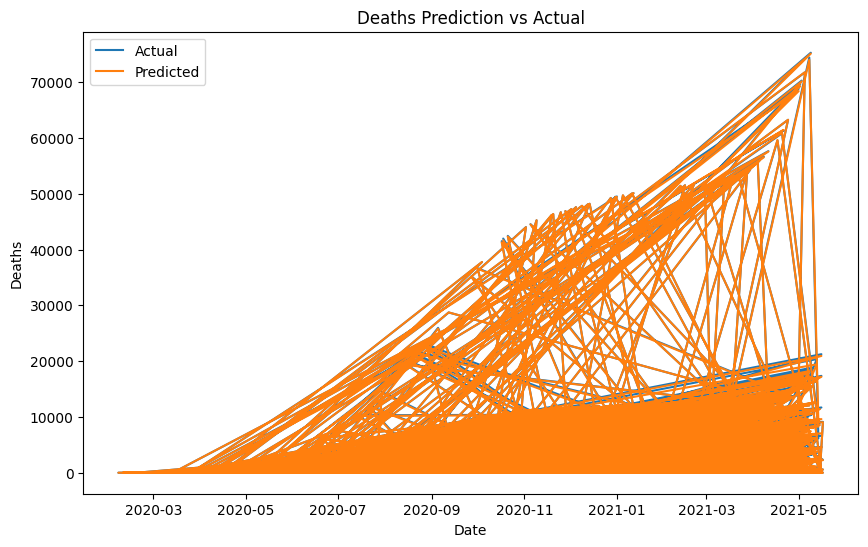

KeyError: 'State/UnionTerritory'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def modified_mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Modified Mean Absolute Percentage Error (MMAPE)

    Parameters:
    y_true : array-like of shape (n_samples,)
        Actual target values.
    y_pred : array-like of shape (n_samples,)
        Predicted target values.

    Returns:
    mmape : float
        Modified Mean Absolute Percentage Error.
    """
    n = len(y_true)
    sum_error = 0

    for i in range(n):
        if y_true[i] != 0:
            error = abs((y_true[i] - y_pred[i]) / y_true[i]) * (1 + abs((y_true[i] - y_pred[i]) / y_true[i]))
        else:
            error = abs(y_true[i] - y_pred[i])
        sum_error += error

    mmape = sum_error / n
    return mmape

# Load dataset
df = pd.read_csv('/content/train_data_covid (1).csv')

# Preprocessing
label_encode = LabelEncoder()
label = label_encode.fit_transform(df['State/UnionTerritory'])
df['State/UnionTerritory'] = label
df.index = pd.to_datetime(df.Date)
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Date'].astype(int)
df['Time'] = df['Time'].astype(int)

# Define features (x) and target (y)
x = df.drop(['Deaths','ConfirmedIndianNational','ConfirmedForeignNational'], axis=1)
y = df['Deaths']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

# Normalize the data with StandardScaler for each feature separately
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the Decision Tree Regressor model
model = ExtraTreesRegressor(random_state=42)

# Define hyperparameters grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# Perform RandomizedSearchCV Cross Validation with more iterations
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=200, cv=5, n_jobs=-1, verbose=2)
random_search.fit(x_train_scaled, y_train_scaled.ravel())

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions
predictions = best_model.predict(x_test_scaled)
predictions_inverse = scaler_y.inverse_transform(predictions.reshape(-1, 1))

# Calculate metrics
mae = mean_absolute_error(y_test, predictions_inverse)
mse = mean_squared_error(y_test, predictions_inverse)
rmse = np.sqrt(mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MMAPE
mmape = modified_mean_absolute_percentage_error(y_test.values, predictions_inverse.flatten())
print("Modified Mean Absolute Percentage Error (MMAPE):", mmape)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions_inverse, label='Predicted')
plt.title('Deaths Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.show()

# Preprocess the test data
test_df = pd.read_csv("/content/test_data_covid (2).csv")
label_encode = LabelEncoder()
label = label_encode.fit_transform(test_df['State/UnionTerritory'])
test_df['State/UnionTerritory'] = label
test_df.index = pd.to_datetime(test_df.Date)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Time'] = pd.to_datetime(test_df['Time'])
test_df['Date'] = test_df['Date'].astype(int)
test_df['Time'] = test_df['Time'].astype(int)
x_test = test_df.drop(['ConfirmedIndianNational', 'ConfirmedForeignNational'], axis=1)
x_test_scaled = scaler_x.transform(x_test)

# Make predictions using the trained model
predictions = best_model.predict(x_test_scaled)

# Reshape the predictions to match the shape expected by the scaler
predictions_reshaped = predictions.reshape(-1, 1)

# Inverse transform the predicted values to obtain the actual scale
predictions_inverse = scaler_y.inverse_transform(predictions_reshaped)

# Extract the target variable (Deaths) from the inverse transformed predictions
predictions_deaths = predictions_inverse.flatten()

# Print the predictions
print("Predicted Deaths:")
print(predictions_deaths)

predictions_df = pd.DataFrame({
    'Sno' : test_df['Sno'],
    'Predicted_Deaths': predictions_deaths
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('/content/test_data_covid (2).csv', index=False)

# Print a message indicating the file is saved
print("Predictions saved to 'predicted_deaths.csv'")

In [ ]:
output_kaggle=pd.read_csv('/content/output.csv')

In [ ]:
output_kaggle


,Sno,Deaths
0,15001.0,394.0
1,15002.0,156.0
2,15003.0,368.0
3,15004.0,6710.0
4,15005.0,1260.0
...,...,...
1048570,NaN,NaN
1048571,NaN,NaN
1048572,NaN,NaN
1048573,NaN,NaN


In [ ]:
predictions_df.isnull().sum()

Sno                 0
Predicted_Deaths    0
dtype: int64

In [ ]:
print("hi")

hi


In [ ]:
X=pd.read_csv('/content/X.csv')
Y=pd.read_csv('/content/Y (1).csv')

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load your dataset


# Define features (X) and target (y)

y =Y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Extra Trees Regressor with default parameters
model = ExtraTreesRegressor(random_state=42)

# Train the model
model.fit(X, Y)

# Make predictions on the test set
y_pred = model.predict(test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


<ipython-input-16-452c936741aa>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, Y)


NameError: name 'test' is not defined

In [ ]:
test_df = pd.read_csv("/content/test_data_covid (2) (2).csv")
label_encode = LabelEncoder()
label = label_encode.fit_transform(test_df['State/UnionTerritory'])
test_df['State/UnionTerritory'] = label
test_df.index = pd.to_datetime(test_df.Date)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Time'] = pd.to_datetime(test_df['Time'])
test_df['Date'] = test_df['Date'].astype(int)
test_df['Time'] = test_df['Time'].astype(int)
x_test = test_df.drop(['ConfirmedIndianNational', 'ConfirmedForeignNational'], axis=1)
x_test_scaled = scaler_x.transform(x_test)

# Make predictions using the trained model
predictions = best_model.predict(x_test_scaled)

# Reshape the predictions to match the shape expected by the scaler
predictions_reshaped = predictions.reshape(-1, 1)

# Inverse transform the predicted values to obtain the actual scale
predictions_inverse = scaler_y.inverse_transform(predictions_reshaped)

# Extract the target variable (Deaths) from the inverse transformed predictions
predictions_deaths = predictions_inverse.flatten()

# Print the predictions
print("Predicted Deaths:")
print(predictions_deaths)

predictions_df = pd.DataFrame({
    'Sno' : test_df['Sno'],
    'Predicted_Deaths': predictions_deaths
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('/content/test_data_covid (2).csv', index=False)

# Print a message indicating the file is saved
print("Predictions saved to 'predicted_deaths.csv'")

Predicted Deaths:
[  348.734   125.652   193.208 ...  5385.894 22135.762 18516.656]
Predictions saved to 'predicted_deaths.csv'


In [ ]:
from google.colab import files
df = pd.DataFrame(predictions_df)

In [ ]:
df.to_csv('array_data.csv', index=False)

# Download CSV file
files.download('array_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>